In [2]:

import pandas as pd

In [3]:

dataset_id = '20240929-165617_f677bbddf5ca38f79f57e1e291c1600d'

#datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,

prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. 
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')


score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')


train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [31]:
score_noisy_X.shape

(7000, 784)

In [4]:


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [9]:
print(train_clean_X.shape, train_noisy_X.shape)
print(validate_clean_X.shape, validate_noisy_X.shape)
print(test_clean_X.shape, test_noisy_X.shape)

(49000, 784) (49000, 784)
(7000, 784) (7000, 784)
(7000, 784) (7000, 784)


In [5]:
import numpy as np


train_noisy_X = np.array(train_noisy_X).reshape(49000, 28, 28, 1)
train_clean_X = np.array(train_clean_X).reshape(49000, 28, 28, 1)
validate_clean_X = np.array(validate_clean_X).reshape(7000, 28, 28, 1)
validate_noisy_X = np.array(validate_noisy_X).reshape(7000, 28, 28, 1)
test_clean_X = np.array(test_clean_X).reshape(7000, 28, 28, 1)
test_noisy_X = np.array(test_noisy_X).reshape(7000, 28, 28, 1)

In [14]:

train_clean_X.shape

(49000, 28, 28)

In [18]:
example_id = 1

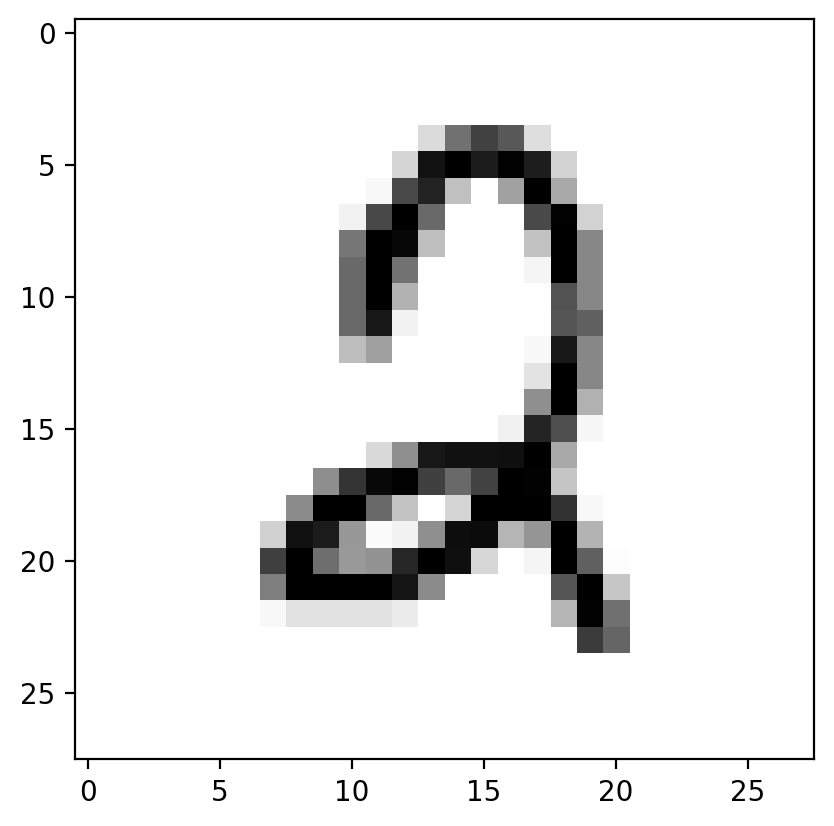

In [19]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X[example_id]


plt.imshow(image_pixels, cmap='binary')

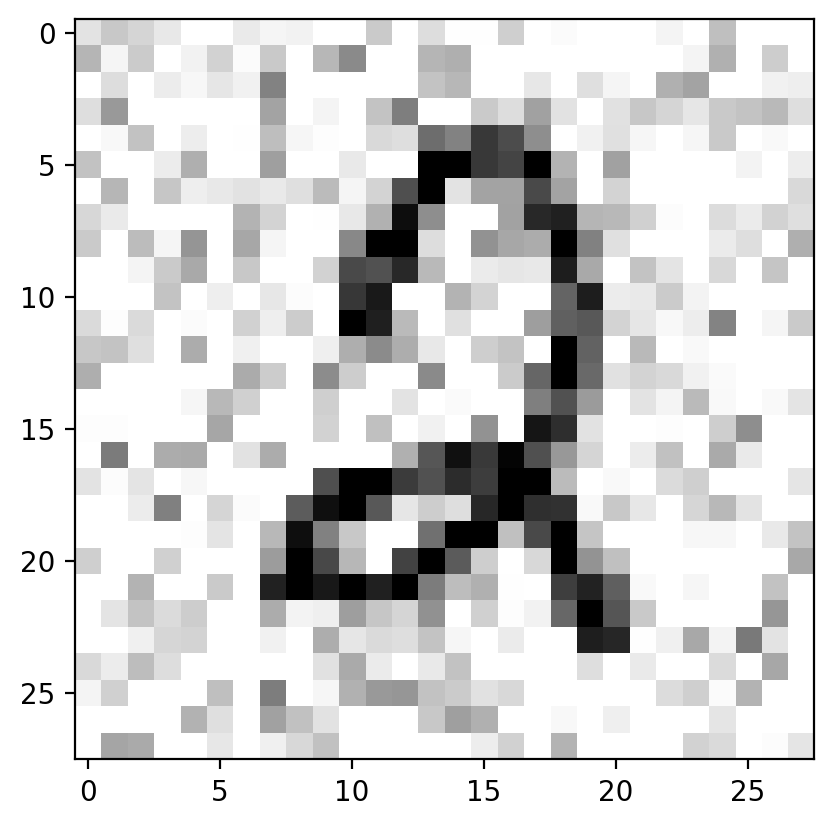

In [20]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X[example_id]



plt.imshow(image_pixels, cmap='binary')

In [9]:
train_y.iloc[example_id]

digit    2
Name: 1, dtype: uint8

In [6]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import mlflow

def build_conv_autoencoder(conv_filters: int, learning_rate_log: float) -> tf.keras.Model:
    
    mlflow.log_param('conv_filters', conv_filters)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    model = Sequential()
    
    # Encoder
    model.add(Conv2D(conv_filters * 2, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    

    
    model.add(Conv2D(conv_filters * 2, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Sigmoid for normalized output

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=10 ** learning_rate_log), 
        loss='mean_squared_error'
    )
    
    return model

In [8]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [9]:

from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_denoising_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [10]:


import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [11]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/110014380484033407', creation_time=1728256322433, experiment_id='110014380484033407', last_update_time=1728256322433, lifecycle_stage='active', name='assignment_01', tags={}>

In [77]:


import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run():
    autoencoder = build_conv_autoencoder(conv_filters=32, learning_rate_log=-4)
    history = train_denoising_model(autoencoder, epochs=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [17]:
train_reconstructed_X = autoencoder.predict(train_anomaly_X)
train_reconstruction_loss = ((train_anomaly_X - train_reconstructed_X) ** 2).sum(axis=1)
train_reconstruction_loss.shape

(98000,)

In [18]:
np.corrcoef(train_reconstruction_loss, train_anomaly_y)

array([[1.        , 0.10703142],
       [0.10703142, 1.        ]])

In [19]:
train_anomaly_y_hat = (train_reconstruction_loss > train_reconstruction_loss.mean())
(train_anomaly_y == train_anomaly_y_hat).mean()

0.5441632653061225

In [78]:
history.history

{'loss': [0.12291219830513,
  0.11236696690320969,
  0.11233849823474884,
  0.11233285069465637,
  0.11233095824718475,
  0.11233017593622208,
  0.11232982575893402,
  0.11232960969209671,
  0.11232948303222656,
  0.11232942342758179],
 'val_loss': [0.11195968836545944,
  0.11189130693674088,
  0.11188099533319473,
  0.11187807470560074,
  0.11187693476676941,
  0.11187642067670822,
  0.11187610030174255,
  0.11187595874071121,
  0.11187585443258286,
  0.1118757501244545]}

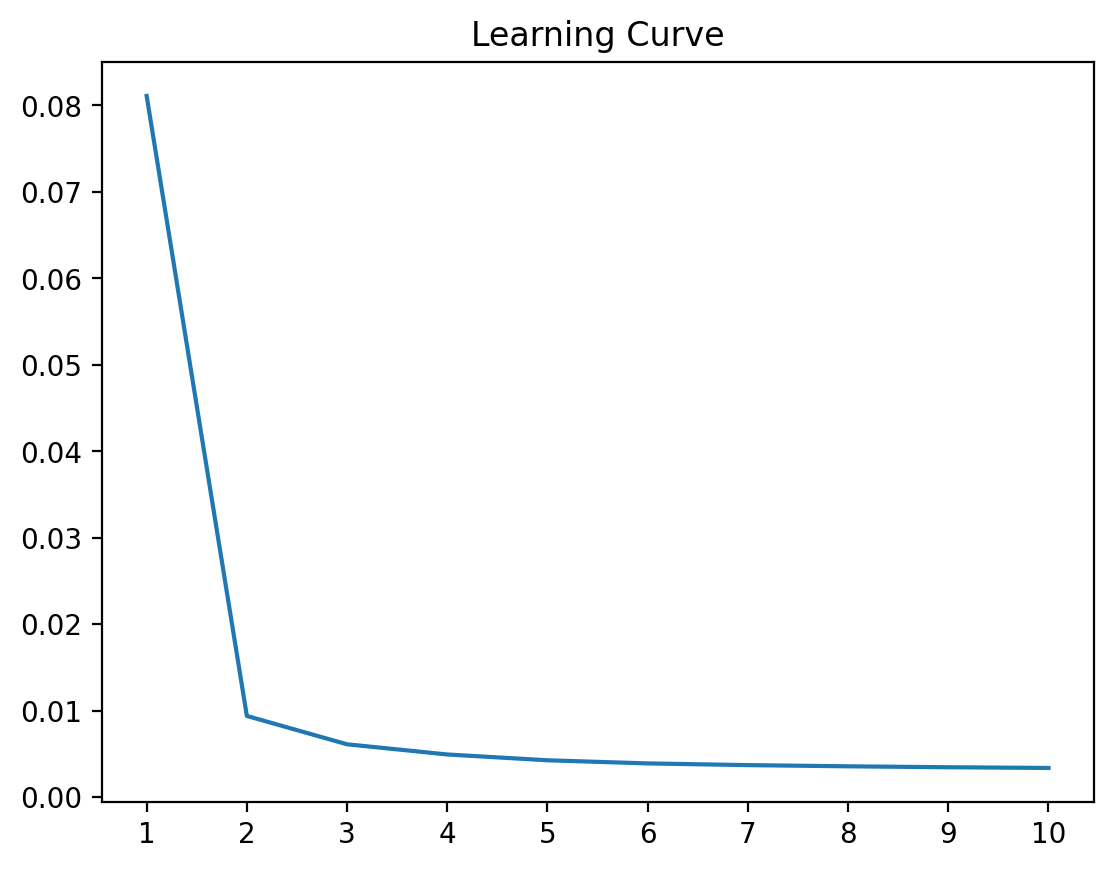

In [75]:

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [15]:
import random
import tqdm

runs = 10
learning_rate_logs = [random.uniform(-5, 0) for _ in range(runs)]
conv_filters = [random.choice([16, 32, 64, 128]) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, conv_filters))

for (learning_rate_log, conv_filters) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_conv_autoencoder(conv_filters=conv_filters, learning_rate_log=learning_rate_log)
        history = train_denoising_model(autoencoder, epochs=15, verbose=0)

 10%|█         | 1/10 [01:26<12:54, 86.07s/it]

 20%|██        | 2/10 [02:48<11:10, 83.86s/it]

 30%|███       | 3/10 [05:34<14:10, 121.52s/it]

 50%|█████     | 5/10 [09:07<08:48, 105.64s/it]

 60%|██████    | 6/10 [10:29<06:31, 97.77s/it] 

 80%|████████  | 8/10 [13:39<02:59, 89.74s/it] 

100%|██████████| 10/10 [15:30<00:00, 93.08s/it]


In [17]:

import mlflow
from mlflow.tracking import MlflowClient

# Instantiate the MLflow Client
client = MlflowClient()


experiment_id = mlflow.get_experiment_by_name("assignment_01").experiment_id

# Get all runs in the experiment, ordering by 'accuracy' in descending order
runs = client.search_runs(experiment_id, order_by=["metrics.accuracy DESC"])

# Select the best run (highest accuracy in this case)
best_run = runs[0]

# Now you can continue with downloading the artifacts or loading the model
best_model_path = client.download_artifacts(best_run.info.run_id, 'model')


autoencoder = load_model(best_model_path)

In [18]:

test_denoised_X = autoencoder.predict(test_noisy_X)



In [24]:
test_denoised_X = test_denoised_X.reshape(7000, 784)

In [28]:
test_clean_X = test_clean_X.reshape(7000, 784)

In [29]:

from sklearn.metrics import mean_squared_error


mean_squared_error(test_denoised_X, test_clean_X)

0.0030104134

In [36]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

score_noisy_X = np.array(score_noisy_X).reshape(7000, 28, 28, 1)


prediction = autoencoder.predict(score_noisy_X).reshape(7000, 784)
prediction = pd.DataFrame(prediction)
score_denoised_X = pd.DataFrame(
    prediction,
    columns=prediction.columns
)



score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

